In [8]:
# Importar Datos de Drones

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

# Importar Datos xlsx (Primera fila nombres de columnas)
data = pd.read_excel('Tarea 2-202420.xlsx', header=1)

# Crear DataFrame
df = pd.DataFrame(data)

# Mostrar DataFrame
print(df.head())

# Conjuntos
drones = [0, 1, 2, 3, 4]  # Conjunto de drones disponibles
Lugares = list(range(26))  # 25 cultivos más el hangar (L = {0,1,2,...,25})

# Lista de arcos entre lugares
A = [(i, j) for i in Lugares for j in Lugares if i != j]

# Distancias entre los lugares (distancia Manhattan)
q = {(i, j): np.abs(df.iloc[i, 1] - df.iloc[j, 1]) + np.abs(df.iloc[i, 2] - df.iloc[j, 2]) for i, j in A}

# Crear el modelo
m = gp.Model('Opti-Drones')

# Variables de decisión: x[d, i, j] = 1 si el dron d viaja de lugar i a lugar j, 0 en caso contrario
x = m.addVars(drones, Lugares, Lugares, vtype=GRB.BINARY, name='x')

# Variables auxiliares u para eliminación de subtours (Miller-Tucker-Zemlin)
u = m.addVars(Lugares, vtype=GRB.CONTINUOUS, name='u')

# Función objetivo: Minimizar la distancia total recorrida por los drones
m.setObjective(gp.quicksum(q[i, j] * x[d, i, j] for d in drones for i, j in A), GRB.MINIMIZE)

# Restricción 1: Todo cultivo debe ser visitado por un dron (llega a i)
for i in Lugares:
    if i != 0:  # El hangar no cuenta
        m.addConstr(gp.quicksum(x[d, j, i] for d in drones for j in Lugares if (j, i) in A) == 1)

# Restricción 2: Todo cultivo debe ser visitado por un dron (sale de i)
for i in Lugares:
    if i != 0:  # El hangar no cuenta
        m.addConstr(gp.quicksum(x[d, i, j] for d in drones for j in Lugares if (i, j) in A) == 1)

# Restricción 3: Se deben utilizar todos los drones (cada dron debe realizar un viaje desde el hangar)
for d in drones:
    m.addConstr(gp.quicksum(x[d, 0, j] for j in Lugares if (0, j) in A) == 1)  # Salida del hangar
    m.addConstr(gp.quicksum(x[d, i, 0] for i in Lugares if (i, 0) in A) == 1)  # Regreso al hangar

# Restricción 4: Balance en cada nodo (número de arcos que entran = número de arcos que salen)
for d in drones:
    for i in Lugares:
        if i != 0:
            m.addConstr(gp.quicksum(x[d, i, j] for j in Lugares if (i, j) in A) == 
                        gp.quicksum(x[d, j, i] for j in Lugares if (j, i) in A))

# Restricciones MTZ para eliminar subtours
for d in drones:
    for i in Lugares:
        for j in Lugares:
            if i != j and i != 0 and j != 0:
                m.addConstr(u[i] - u[j] + (len(Lugares)) * x[d, i, j] <= len(Lugares) - 1)

# Optimizar el modelo
m.optimize()

# Imprimir resultados
if m.status == GRB.OPTIMAL:
    print(f"Solución óptima encontrada con un valor objetivo de: {m.objVal}")

  1727  1547  320.35897   24   32  354.00000  296.00000  16.4%   9.7   10s
H 1729  1470                     346.0000000  296.00000  14.5%   9.7   11s
H 1729  1396                     322.0000000  296.00000  8.07%   9.7   11s
  1754  1415  322.00000  167   34  322.00000  296.00000  8.07%  10.3   15s
* 2437  1631              35     320.0000000  298.07692  6.85%  14.7   17s
* 2628  1526              42     318.0000000  298.07692  6.27%  14.8   17s
H 2789  1451                     316.0000000  298.30769  5.60%  15.0   18s
H 2799  1386                     312.0000000  298.30769  4.39%  15.0   18s
* 3377  1285              39     310.0000000  299.25962  3.46%  15.0   19s
* 3595  1196              30     308.0000000  302.12821  1.91%  15.1   19s
  3808  1123  304.61538   38   26  308.00000  304.00000  1.30%  15.1   20s

Cutting planes:
  Gomory: 31
  Cover: 5
  Implied bound: 27
  Projected implied bound: 1
  Clique: 3
  MIR: 9
  Flow cover: 52
  Inf proof: 15
  Zero half: 28
  RLT: 112

Exp

In [9]:
# Imprimir la solución
for d in drones:
    print(f"Tour del dron {d}:")
    for i in Lugares:
        for j in Lugares:
            if x[d, i, j].x > 0.5:
                print(f"El dron {d} viaja de {i} a {j}")

Tour del dron 0:
El dron 0 viaja de 0 a 22
El dron 0 viaja de 22 a 0
Tour del dron 1:
El dron 1 viaja de 0 a 13
El dron 1 viaja de 13 a 0
Tour del dron 2:
El dron 2 viaja de 0 a 18
El dron 2 viaja de 18 a 0
Tour del dron 3:
El dron 3 viaja de 0 a 9
El dron 3 viaja de 9 a 0
Tour del dron 4:
El dron 4 viaja de 0 a 24
El dron 4 viaja de 1 a 8
El dron 4 viaja de 2 a 5
El dron 4 viaja de 3 a 23
El dron 4 viaja de 4 a 17
El dron 4 viaja de 5 a 19
El dron 4 viaja de 6 a 3
El dron 4 viaja de 7 a 15
El dron 4 viaja de 8 a 11
El dron 4 viaja de 10 a 2
El dron 4 viaja de 11 a 0
El dron 4 viaja de 12 a 4
El dron 4 viaja de 14 a 12
El dron 4 viaja de 15 a 25
El dron 4 viaja de 16 a 6
El dron 4 viaja de 17 a 1
El dron 4 viaja de 19 a 7
El dron 4 viaja de 20 a 10
El dron 4 viaja de 21 a 14
El dron 4 viaja de 23 a 21
El dron 4 viaja de 24 a 20
El dron 4 viaja de 25 a 16


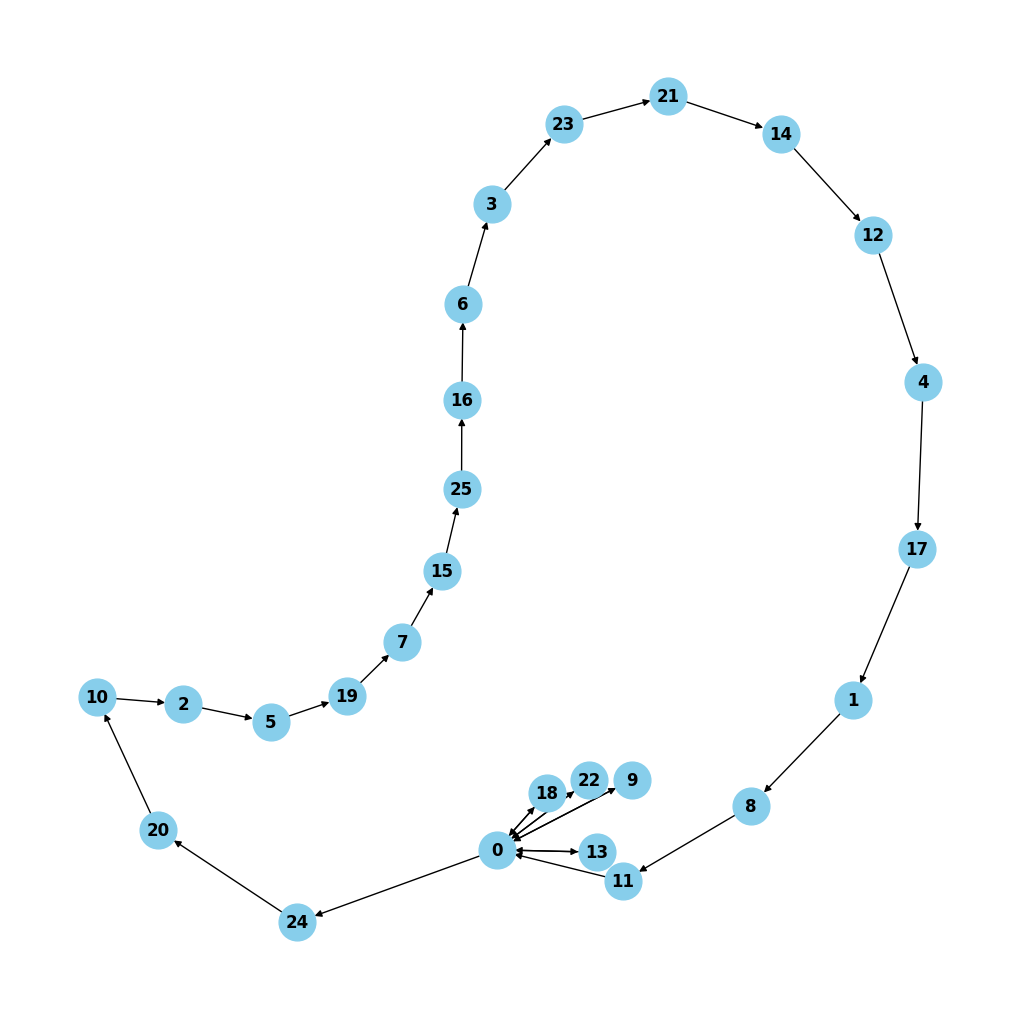

In [10]:
# Dibujar grafo de la solución (colocando nodos adyacentes más cerca)
import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()

# Agregar las aristas del grafo
for i, j in A:
    for d in drones:
        if x[d, i, j].x > 0.5:
            G.add_edge(i, j)

# Ajuste del layout con resorte (spring_layout)
# Aquí 'k' controla la distancia entre nodos. Valores más pequeños hacen que los nodos estén más cerca.
# Aumentar las iteraciones para un ajuste más preciso.
pos = nx.spring_layout(G, k=0.2, iterations=150)  # Ajustar k para reducir la distancia entre nodos adyacentes

# Dibujar los nodos y arcos del grafo
plt.figure(figsize=(10, 10))  # Ajustar el tamaño de la figura para mayor claridad
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=12, font_weight='bold')

# Si tienes etiquetas para los arcos, por ejemplo, las distancias recorridas
labels = nx.get_edge_attributes(G, 'weight')

# Dibujar etiquetas de los arcos si existen
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Mostrar el grafo
plt.show()
